<a href="https://colab.research.google.com/github/ahmadrathore/Provisioning-SmartX-MicroBox/blob/master/4_GRU_Multivariate_Horizon_Style_FlowData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
tf.random.set_seed(123)
np.random.seed(123)

In [86]:
#df = pd.read_csv(r'merge-csv.com__602f0aa73c265.csv')
#df = pd.read_csv('merge-csv.com__602f0aa73c265.csv',index_col='Processing_time',
#                infer_datetime_format=True)

url='https://raw.githubusercontent.com/ahmadrathore/Provisioning-SmartX-MicroBox/master/kafka9092_Network-Flows.csv'

df = pd.read_csv(url,index_col='Processing_time',
                infer_datetime_format=True)



In [87]:
df.head()

,Measurement_boxname,src_host_port,dest_host_port,protocol,protocol_count,min_tcp_window_size,max_tcp_window_size,avg_tcp_window_size,std_dev_tcp_window_size,min_data_bytes,max_data_bytes,avg_databytes,std_dev_databytes,total_data_bytes,flow_duration
Processing_time,,,,,,,,,,,,,,,
2020-12-01T00:05:24.998+09:00,smartx-microbox-gist-1,39846,9092,6,183,2438,2439,2439,0.07,161,11888,2788.26,2591.23,510252,170.018
2020-12-01T00:10:44.861+09:00,smartx-microbox-gist-1,39846,9092,6,396,2438,2439,2439,0.11,63,11856,2228.37,2094.46,882435,290.016
2020-12-01T00:15:33.979+09:00,smartx-microbox-gist-1,39846,9092,6,395,2438,2439,2439,0.13,102,13084,2209.62,2321.09,872801,290.017
2020-12-01T00:25:41.464+09:00,smartx-microbox-gist-1,39846,9092,6,459,2438,2439,2439,0.09,61,11550,1989.66,1919.81,913254,290.017
2020-12-01T00:35:18.114+09:00,smartx-microbox-gist-1,39846,9092,6,456,2438,2439,2439,0.09,87,11544,1981.21,1909.48,903430,290.011


In [88]:
df.describe()

,src_host_port,dest_host_port,protocol,protocol_count,min_tcp_window_size,max_tcp_window_size,avg_tcp_window_size,std_dev_tcp_window_size,min_data_bytes,max_data_bytes,avg_databytes,std_dev_databytes,total_data_bytes,flow_duration
count,8576.000000,8576.0,8576.0,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000
mean,40807.862873,9092.0,6.0,362.090602,2315.889576,2317.284632,2316.846782,0.317004,76.953708,10271.796525,2104.136580,2048.747845,761531.681087,279.171818
std,3907.567979,0.0,0.0,56.159077,395.897535,394.644232,395.614646,1.226467,19.597907,1867.873236,175.951136,231.740512,131589.840309,34.988489
min,33560.000000,9092.0,6.0,22.000000,499.000000,501.000000,501.000000,0.000000,59.000000,5971.000000,1387.150000,1291.840000,44072.000000,10.014000
25%,39846.000000,9092.0,6.0,340.000000,2438.000000,2439.000000,2439.000000,0.000000,62.000000,8740.000000,1973.480000,1867.347500,686703.750000,290.015000
50%,39846.000000,9092.0,6.0,369.000000,2438.000000,2439.000000,2439.000000,0.050000,69.000000,10587.000000,2094.890000,2032.635000,709585.000000,290.016000
75%,40442.000000,9092.0,6.0,398.000000,2439.000000,2439.000000,2439.000000,0.100000,88.000000,11718.000000,2226.530000,2229.402500,882164.750000,290.017000
max,59584.000000,9092.0,6.0,514.000000,2439.000000,2439.000000,2439.000000,21.950000,264.000000,14764.000000,2899.900000,2856.150000,923288.000000,290.056000


In [89]:
#df.drop_duplicates(subset=['date_time'], keep=False,inplace=True)

In [90]:
Measurement_boxname_le = preprocessing.LabelEncoder()
df['Measurement_boxname_le'] = Measurement_boxname_le.fit_transform(df['Measurement_boxname']) 

In [91]:
df = df[['min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes', 'Measurement_boxname_le']]

In [92]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [93]:
validate = df[['min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes', 'Measurement_boxname_le']].tail(40)
df.drop(df.tail(40).index,inplace=True)

In [94]:
x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
dataX = x_scaler.fit_transform(df[['Measurement_boxname_le','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes']])
dataY = y_scaler.fit_transform(df[['total_data_bytes']])

In [95]:
hist_window = 80
horizon = 40
TRAIN_SPLIT = 5500
x_train_multi, y_train_multi = custom_ts_multi_data_prep(
    dataX, dataY, 0, TRAIN_SPLIT, hist_window, horizon)
x_val_multi, y_val_multi = custom_ts_multi_data_prep(
    dataX, dataY, TRAIN_SPLIT, None, hist_window, horizon)

In [96]:
print ('Single window of past history')
print(x_train_multi[0])
print ('\n Target horizon')
print (y_train_multi[0])

Single window of past history
[[0.         0.49756098 0.67292164 0.92620063 0.83064738 0.53022238]
 [0.         0.0195122  0.66928238 0.5560866  0.51308245 0.95353474]
 [0.         0.2097561  0.80893893 0.54369195 0.65795782 0.94257725]
 [0.         0.0097561  0.63448197 0.39828789 0.40143578 0.98858756]
 [0.         0.13658537 0.63379961 0.39270203 0.39483223 0.97741397]
 [0.         0.20487805 0.66666667 0.49240787 0.48279433 0.96592077]
 [0.         0.01463415 0.64426248 0.55013056 0.65527932 0.94442549]
 [0.         0.04390244 0.70214944 0.51846637 0.54657325 0.95507134]
 [0.         0.10731707 0.59683839 0.655647   0.66667732 0.94831418]
 [0.         0.0097561  0.64630956 0.45051066 0.49403891 0.96630407]
 [0.         0.24390244 0.66518822 0.48702694 0.55472381 0.55379224]
 [0.         0.0097561  0.80893893 0.41813254 0.42267198 0.96750514]
 [0.         0.0097561  0.59126578 0.41946786 0.50295018 0.97082287]
 [0.         0.0097561  0.80893893 0.58135184 0.68869342 0.94239072]
 [0.

In [97]:
BATCH_SIZE = 256
BUFFER_SIZE = 150

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [98]:
GRU_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(100, input_shape=x_train_multi.shape[-2:],return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(units=50,return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
GRU_model.compile(optimizer='adam', loss='mse')


In [99]:
model_path = r'GRU_Multivariate.h5'

In [100]:
EVALUATION_INTERVAL = 100
EPOCHS = 100
history = GRU_model.fit(train_data_multi, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_data_multi, validation_steps=50,verbose =1,
                              callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/100
100/100 [==============================] - 8s 50ms/step - loss: 0.3341 - val_loss: 0.0100
Epoch 2/100
100/100 [==============================] - 4s 39ms/step - loss: 0.0431 - val_loss: 0.0108
Epoch 3/100
100/100 [==============================] - 4s 39ms/step - loss: 0.0327 - val_loss: 0.0114
Epoch 4/100
100/100 [==============================] - 4s 39ms/step - loss: 0.0291 - val_loss: 0.0094
Epoch 5/100
100/100 [==============================] - 4s 39ms/step - loss: 0.0253 - val_loss: 0.0094
Epoch 6/100
100/100 [==============================] - 4s 39ms/step - loss: 0.0226 - val_loss: 0.0094
Epoch 7/100
100/100 [==============================] - 4s 39ms/step - loss: 0.0218 - val_loss: 0.0094
Epoch 8/100
100/100 [==============================] - 4s 39ms/step - loss: 0.0207 - val_loss: 0.0095
Epoch 9/100
100/100 [==============================] - 4s 39ms/step - loss: 0.0203 - val_loss: 0.0096
Epoch 10/100
100/100 [==============================] - 4s 39ms/step - loss: 0.019

In [101]:
Trained_model = tf.keras.models.load_model(model_path)

In [102]:
# Show the model architecture
Trained_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 80, 100)           32400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 80, 100)           0         
_________________________________________________________________
gru_7 (GRU)                  (None, 50)                22800     
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2040      
Total params: 57,240
Trainable params: 57,240
Non-trainable params: 0
_________________________________________________________________


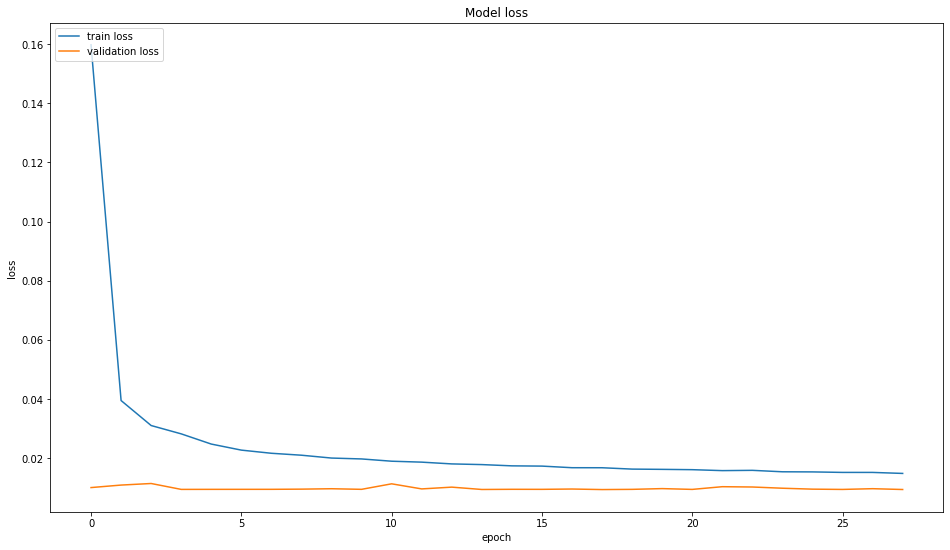

In [103]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [104]:
data_val = x_scaler.fit_transform(df[['Measurement_boxname_le','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes']].tail(80))

In [105]:
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

In [106]:
Predicted_results = Trained_model.predict(val_rescaled)

In [107]:
Predicted_results

array([[0.7931421 , 0.79989755, 0.80919737, 0.7974859 , 0.79750586,
        0.7937714 , 0.79887223, 0.79680324, 0.79379535, 0.80267096,
        0.8017391 , 0.82067275, 0.81232905, 0.8129582 , 0.80152804,
        0.80901796, 0.81063724, 0.80060196, 0.79443526, 0.79387164,
        0.7892485 , 0.7932619 , 0.79532385, 0.7923009 , 0.785376  ,
        0.80760676, 0.8075073 , 0.7971765 , 0.8066029 , 0.7883714 ,
        0.7951805 , 0.7873604 , 0.8011918 , 0.80646676, 0.7988274 ,
        0.81412685, 0.813298  , 0.79307806, 0.79425085, 0.794998  ]],
      dtype=float32)

In [108]:
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results)

In [109]:
Predicted_results_Inv_trans

array([[741415.25, 747354.75, 755531.3 , 745234.4 , 745251.94, 741968.5 ,
        746453.25, 744634.2 , 741989.56, 749793.2 , 748973.9 , 765620.6 ,
        758284.7 , 758837.9 , 748788.3 , 755373.56, 756797.25, 747974.06,
        742552.2 , 742056.7 , 737991.94, 741520.56, 743333.44, 740675.6 ,
        734587.2 , 754132.8 , 754045.3 , 744962.3 , 753250.2 , 737220.75,
        743207.44, 736331.9 , 748492.7 , 753130.5 , 746413.9 , 759865.4 ,
        759136.6 , 741358.94, 742390.06, 743046.94]], dtype=float32)

In [110]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [111]:
timeseries_evaluation_metrics_func(validate['total_data_bytes'],Predicted_results_Inv_trans[0])

Evaluation metric results:-
MSE is : 6689532472.267578
MAE is : 32294.328125
RMSE is : 81789.56212297251
MAPE is : 6.24439587489918
R2 is : -0.03135096469340848



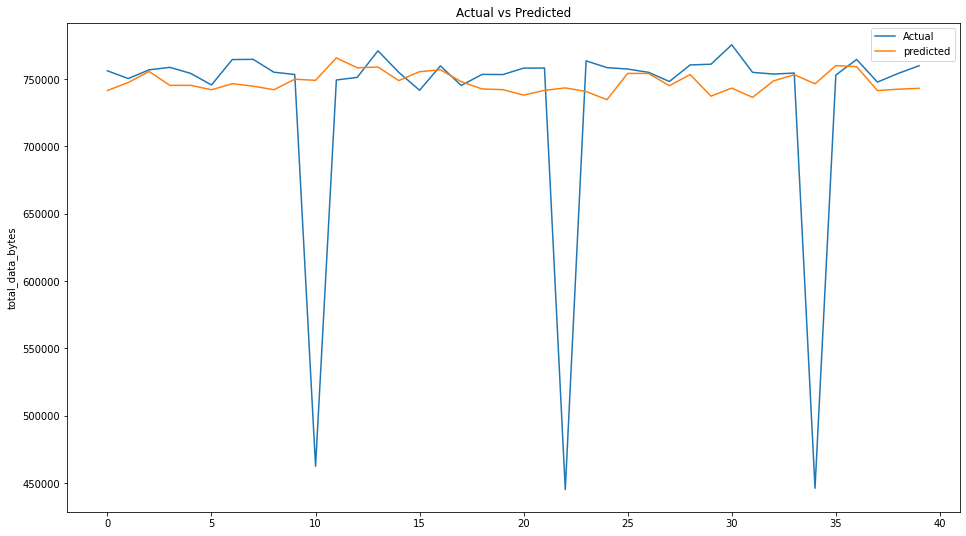

In [112]:


plt.plot( list(validate['total_data_bytes']))
plt.plot( list(Predicted_results_Inv_trans[0]))
plt.title("Actual vs Predicted")
plt.ylabel("total_data_bytes")
plt.legend(('Actual','predicted'))
plt.show()
